In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, TargetEncoder

from sklearn.metrics import roc_auc_score, classification_report

from sklearn.inspection import permutation_importance

In [ ]:
kyc_details = pd.read_csv('KYC_details.csv')
kyc_summary = pd.read_csv('KYC_summary.csv')

In [3]:
kyc_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52075 entries, 0 to 52074
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   user_reference                 52075 non-null  float64
 1   decision_label                 52075 non-null  object 
 2   usability_decision             52075 non-null  object 
 3   usability_decision_details     52075 non-null  object 
 4   image_checks_decision          52075 non-null  object 
 5   image_checks_decision_details  52075 non-null  object 
 6   extraction_decision            52075 non-null  object 
 7   extraction_decision_details    52075 non-null  object 
 8   data_checks_decision           52075 non-null  object 
 9   data_checks_decision_details   52075 non-null  object 
 10  liveness_decision              52075 non-null  object 
 11  liveness_decision_details      52075 non-null  object 
 12  similarity_decision            52075 non-null 

In [4]:
kyc_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52075 entries, 0 to 52074
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date_           52075 non-null  object 
 1   user_reference  52075 non-null  float64
 2   decision_type   52075 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.2+ MB


In [5]:
kyc_summary["decision_type"].unique()

array(['PASSED', 'REJECTED', 'WARNING', 'APPROVED'], dtype=object)

In [6]:
df = pd.merge(kyc_summary, kyc_details, on='user_reference', how='left')

In [7]:
df['date_'] = pd.to_datetime(df['date_'])
df['is_pass'] = df['decision_type'].isin(['PASSED', 'APPROVED']).astype(int)

In [8]:
df['date_'].min(), df['date_'].max()

(Timestamp('2023-07-25 00:00:00+0000', tz='UTC'),
 Timestamp('2023-09-22 00:00:00+0000', tz='UTC'))

In [9]:
daily_stats = df.groupby('date_')['is_pass'].agg(['count', 'sum', 'mean']).reset_index()
daily_stats.columns = ['date', 'total_attempts', 'passes', 'pass_rate']

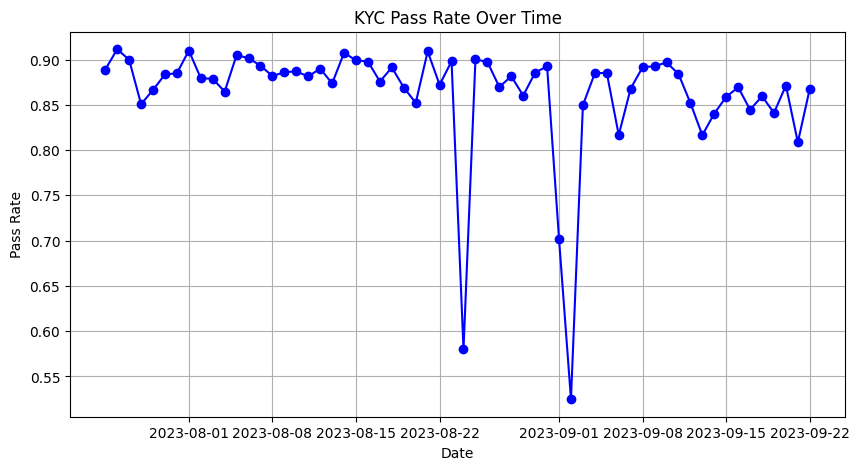

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(daily_stats['date'], daily_stats['pass_rate'], marker='o', linestyle='-', color='b')
plt.title('KYC Pass Rate Over Time')
plt.ylabel('Pass Rate')
plt.xlabel('Date')
plt.grid(True)
plt.show()

In [11]:
df['week'] = df['date_'].dt.to_period('W').apply(lambda r: r.start_time)

weekly_stats = df.groupby('week')['is_pass'].agg(['count', 'sum', 'mean']).reset_index()
weekly_stats.columns = ['week', 'total_attempts', 'passes', 'pass_rate']

/tmp/ipython-input-3054958010.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['week'] = df['date_'].dt.to_period('W').apply(lambda r: r.start_time)


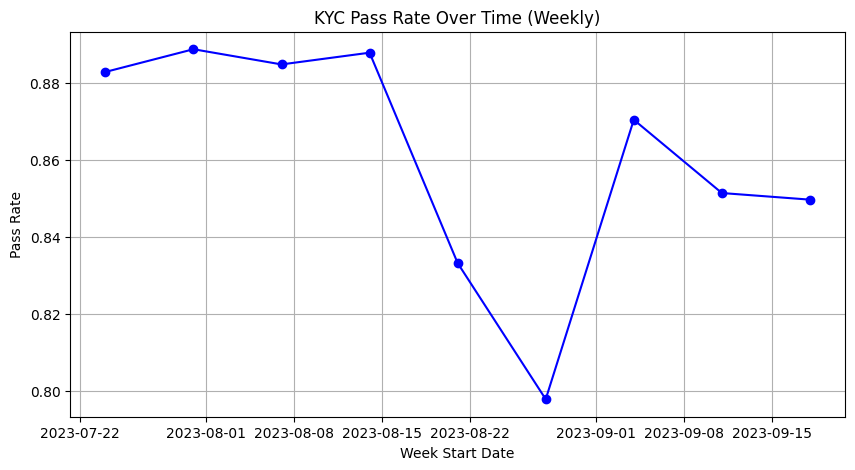

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(weekly_stats['week'], weekly_stats['pass_rate'], marker='o', linestyle='-', color='b')
plt.title('KYC Pass Rate Over Time (Weekly)')
plt.ylabel('Pass Rate')
plt.xlabel('Week Start Date')
plt.grid(True)
plt.show()

In [13]:
missing_watchlist = df[df['watchlist_screening_decision'].isna()].copy(deep=True)

In [14]:
watchlist_outcomes = missing_watchlist['decision_type'].value_counts()
print(watchlist_outcomes)

decision_type
REJECTED    6521
PASSED        81
APPROVED       4
Name: count, dtype: int64


In [15]:
prior_checks = ['usability_decision', 'image_checks_decision', 'extraction_decision', 'liveness_decision']
missing_watchlist['has_prior_failure'] = missing_watchlist[prior_checks].apply(lambda row: (row != 'PASSED').any(), axis=1)

In [16]:
missing_watchlist['has_prior_failure'].mean()

np.float64(0.8374205267938238)

In [17]:
anomalies = df[
    (df['decision_type'].isin(['PASSED', 'APPROVED'])) &
    (df['watchlist_screening_decision'].isna())
]
df_clean = df.drop(anomalies.index).copy(deep=True)

In [120]:
df_clean['image_checks_decision_details'].unique()

array(['OK', 'PRECONDITION_NOT_FULFILLED', 'TECHNICAL_ERROR',
       'DIGITAL_COPY', 'MANIPULATED_DOCUMENT_DOB', 'MANIPULATED_DOCUMENT',
       'OTHER_REJECTION', 'MANIPULATED_DOCUMENT_PHOTO',
       'MANIPULATED_DOCUMENT_DOCUMENT_NUMBER',
       'MANIPULATED_DOCUMENT_SECURITY_CHECKS', 'PUNCHED',
       'MISMATCH_FRONT_BACK', 'FAKE', 'MANIPULATED_DOCUMENT_NAME',
       'MANIPULATED_DOCUMENT_EXPIRY'], dtype=object)

In [119]:
df_clean['usability_decision_details'].unique()

array(['OK', 'MISSING_MANDATORY_DATAPOINTS', 'GLARE',
       'UNSUPPORTED_DOCUMENT_TYPE', 'liveness_UNDETERMINED',
       'MISSING_PAGE', 'BLURRED', 'NOT_UPLOADED', 'DAMAGED_DOCUMENT',
       'NOT_A_DOCUMENT', 'PHOTOCOPY', 'PASSED', 'TECHNICAL_ERROR',
       'PART_OF_DOCUMENT_MISSING', 'PART_OF_DOCUMENT_HIDDEN'],
      dtype=object)

In [18]:
fraud_keywords = [
    'DIGITAL_COPY', 'MANIPULATED', 'FAKE', 'PUNCHED',
    'MISMATCH_FRONT_BACK', 'PHOTOCOPY'
]
fraud_pattern = '|'.join(fraud_keywords)

df_clean['is_confirmed_fraud'] = (
    df_clean['image_checks_decision_details'].astype(str).str.contains(fraud_pattern, case=False, na=False) |
    df_clean['usability_decision_details'].astype(str).str.contains('PHOTOCOPY', case=False, na=False)
).astype(int)

In [19]:
quality_keywords = [
    'GLARE', 'BLURRED', 'MISSING_PAGE', 'NOT_UPLOADED',
    'DAMAGED_DOCUMENT', 'PART_OF_DOCUMENT_MISSING', 'PART_OF_DOCUMENT_HIDDEN',
    'BAD_QUALITY', 'FACE_NOT_FULLY_VISIBLE', 'liveness_UNDETERMINED'
]
quality_pattern = '|'.join(quality_keywords)

df_clean['is_quality_fail'] = (
    df_clean['usability_decision_details'].astype(str).str.contains(quality_pattern, case=False, na=False) |
    df_clean['liveness_decision_details'].astype(str).str.contains(quality_pattern, case=False, na=False)
).astype(int)

In [20]:
df_clean['is_face_mismatch'] = (df_clean['similarity_decision_details'] == 'NO_MATCH').astype(int)
df_clean['is_unsupported_doc'] = df_clean['usability_decision_details'].isin(['UNSUPPORTED_DOCUMENT_TYPE', 'NOT_A_DOCUMENT']).astype(int)

In [21]:
tech_fail_keywords = ['TECHNICAL_ERROR', 'MISMATCHING_DATAPOINTS', 'MISMATCH_HRZ_MRZ_DATA']
tech_pattern = '|'.join(tech_fail_keywords)

df_clean['is_tech_data_fail'] = (
    df_clean['data_checks_decision_details'].astype(str).str.contains(tech_pattern, case=False, na=False) |
    df_clean['extraction_decision_details'].astype(str).str.contains(tech_pattern, case=False, na=False)
).astype(int)

In [22]:
bins = [0, 18, 25, 35, 45, 55, 100]
labels = ['<18', '18-25', '26-35', '36-45', '46-55', '55+']

df_clean['proxy_age'] = 2023 - pd.to_numeric(df_clean['year_birth'], errors='coerce')
df_clean['age_group'] = pd.cut(df_clean['proxy_age'], bins=bins, labels=labels).astype(str).replace('nan', 'Unknown')

In [23]:
cols_to_fill = ['data_issuing_country', 'data_type', 'data_sub_type']
for col in cols_to_fill:
    df_clean[col] = df_clean[col].fillna('UNKOWN')

In [24]:
df_clean['combo_country_type'] = df_clean['data_issuing_country'] + "_" + df_clean['data_type']
df_clean['combo_country_subtype'] = df_clean['data_issuing_country'] + "_" + df_clean['data_sub_type']
df_clean['combo_country_age'] = df_clean['data_issuing_country'] + "_" + df_clean['age_group']
df_clean['combo_type_age'] = df_clean['data_type'] + "_" + df_clean['age_group']

In [55]:
categorical_cols = [
    'data_issuing_country',
    'data_type',
    'data_sub_type',
    'age_group',
    'combo_country_type',
    'combo_country_subtype',
    'combo_country_age',
    'combo_type_age',
]

binary_features = [
    'is_confirmed_fraud',
    'is_quality_fail',
    'is_face_mismatch',
    'is_tech_data_fail',
    'is_unsupported_doc'
]

In [56]:
X = df_clean[categorical_cols+binary_features]
y = df_clean['is_pass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [57]:
model_features_train = X_train[binary_features].copy()
model_features_test = X_test[binary_features].copy()

In [58]:
te = TargetEncoder(smooth="auto", cv=5, random_state=42)

for col in categorical_cols:
    te.fit(X_train[[col]], y_train)
    model_features_train[f"{col}_TE"] = te.transform(X_train[[col]]).flatten()
    model_features_test[f"{col}_TE"] = te.transform(X_test[[col]]).flatten()


    counts = X_train[col].value_counts()
    model_features_train[f"{col}_CE"] = X_train[col].map(counts).fillna(0)
    model_features_test[f"{col}_CE"] = X_test[col].map(counts).fillna(0)

In [59]:
model = xgb.XGBClassifier(random_state=42)
model.fit(model_features_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [60]:
y_predict_proba = model.predict_proba(model_features_test)
y_predict = model.predict(model_features_test)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      2200
           1       0.98      1.00      0.99     13397

    accuracy                           0.98     15597
   macro avg       0.98      0.95      0.97     15597
weighted avg       0.98      0.98      0.98     15597



In [61]:
roc_auc_score(y_test, y_predict_proba[:,1])

np.float64(0.9635023614513426)

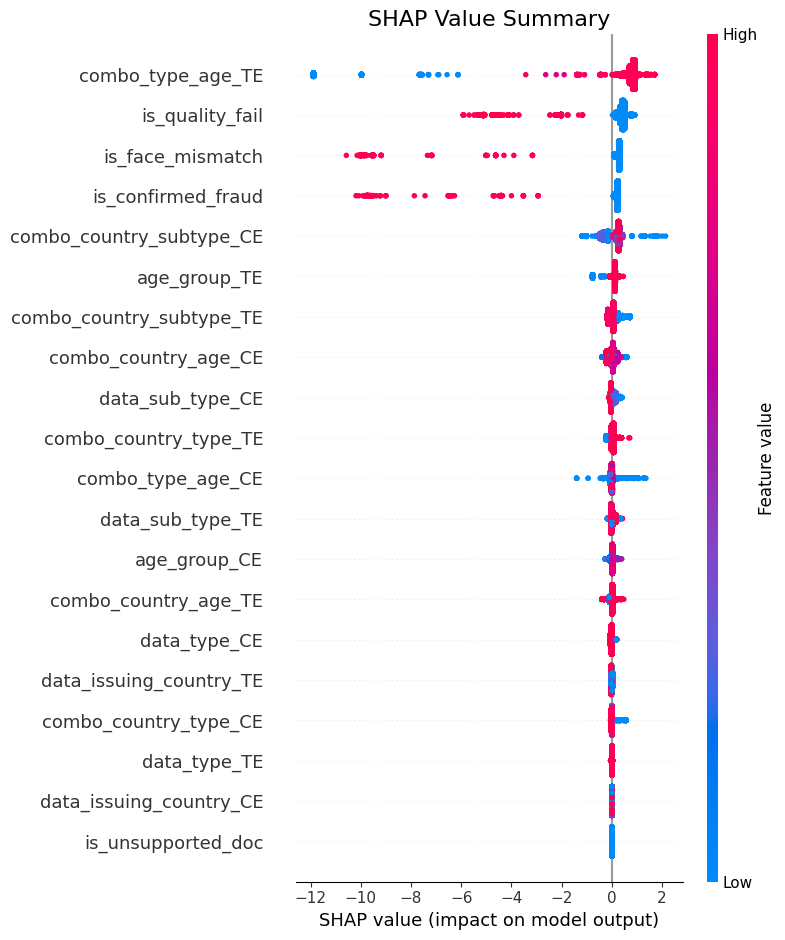

In [62]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(model_features_test)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, model_features_test, show=False)
plt.title("SHAP Value Summary", fontsize=16)
plt.tight_layout()

In [63]:
def analyze_feature_groups(df, feature):
    stats = df.groupby(feature)['is_pass'].agg(['count', 'mean', 'sum']).reset_index()
    stats.columns = [feature, 'Total Attempts', 'Pass Rate', 'Passed Count']
    stats['Fail Count'] = stats['Total Attempts'] - stats['Passed Count']
    stats = stats.sort_values('Pass Rate', ascending=True)
    return stats

In [64]:
group_stats_type_age = analyze_feature_groups(df_clean, 'combo_type_age')
meaningful_type_age = group_stats_type_age[group_stats_type_age['Total Attempts'] > 10]
meaningful_type_age.head(10)

,combo_type_age,Total Attempts,Pass Rate,Passed Count,Fail Count
20,UNKOWN_Unknown,3762,0.000000,0,3762
3,DRIVING_LICENSE_46-55,136,0.852941,116,20
5,DRIVING_LICENSE_<18,37,0.891892,33,4
2,DRIVING_LICENSE_36-45,196,0.897959,176,20
4,DRIVING_LICENSE_55+,82,0.902439,74,8
0,DRIVING_LICENSE_18-25,195,0.902564,176,19
1,DRIVING_LICENSE_26-35,320,0.915625,293,27
11,ID_CARD_55+,1814,0.917310,1664,150
8,ID_CARD_26-35,15088,0.919804,13878,1210
9,ID_CARD_36-45,9009,0.921967,8306,703


In [86]:
group_stats_type_age = analyze_feature_groups(df_clean, 'data_type')
meaningful_type_age = group_stats_type_age[group_stats_type_age['Total Attempts'] > 10]
meaningful_type_age.head(10)

,data_type,Total Attempts,Pass Rate,Passed Count,Fail Count
3,UNKOWN,3762,0.000000,0,3762
0,DRIVING_LICENSE,971,0.894954,869,102
1,ID_CARD,44574,0.926280,41288,3286
4,VISA,24,0.958333,23,1
2,PASSPORT,2659,0.964272,2564,95


In [88]:
group_stats_type_age = analyze_feature_groups(df_clean, 'age_group')
meaningful_type_age = group_stats_type_age[group_stats_type_age['Total Attempts'] > 10]
meaningful_type_age.head(10)

,age_group,Total Attempts,Pass Rate,Passed Count,Fail Count
6,Unknown,3771,0.000265,1,3770
4,55+,2061,0.921883,1900,161
1,26-35,16400,0.922195,15124,1276
2,36-45,9911,0.924831,9166,745
3,46-55,4915,0.924924,4546,369
0,18-25,12508,0.936441,11713,795
5,<18,2424,0.946370,2294,130


In [89]:
categorical_cols = [
    'data_issuing_country',
    'data_sub_type',
    'combo_country_type',
    'combo_country_subtype',
    'combo_country_age',
]

binary_features = [
    'is_confirmed_fraud',
    'is_quality_fail',
    'is_face_mismatch',
    'is_tech_data_fail',
    'is_unsupported_doc'
]

In [90]:
X = df_clean[categorical_cols+binary_features]
y = df_clean['is_pass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [91]:
model_features_train = X_train[binary_features].copy()
model_features_test = X_test[binary_features].copy()

In [92]:
te = TargetEncoder(smooth="auto", cv=5, random_state=42)

In [93]:
for col in categorical_cols:
    te.fit(X_train[[col]], y_train)
    model_features_train[f"{col}_TE"] = te.transform(X_train[[col]]).flatten()
    model_features_test[f"{col}_TE"] = te.transform(X_test[[col]]).flatten()


    counts = X_train[col].value_counts()
    model_features_train[f"{col}_CE"] = X_train[col].map(counts).fillna(0)
    model_features_test[f"{col}_CE"] = X_test[col].map(counts).fillna(0)

In [94]:
model = xgb.XGBClassifier(random_state=42)
model.fit(model_features_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [95]:
y_predict_proba = model.predict_proba(model_features_test)
y_predict = model.predict(model_features_test)

In [96]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2200
           1       0.99      1.00      0.99     13397

    accuracy                           0.98     15597
   macro avg       0.98      0.95      0.97     15597
weighted avg       0.98      0.98      0.98     15597



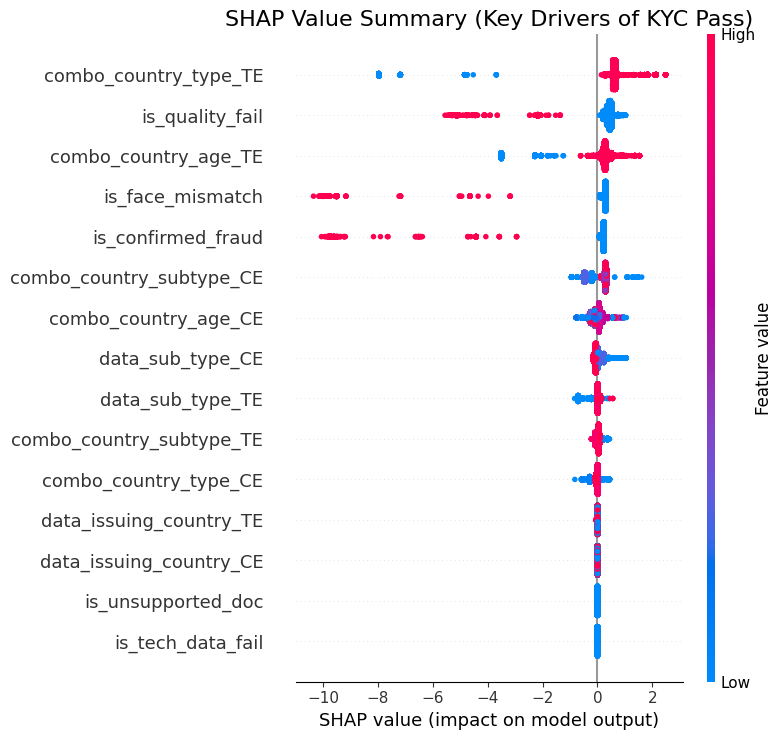

In [97]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(model_features_test)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, model_features_test, show=False)
plt.title("SHAP Value Summary (Key Drivers of KYC Pass)", fontsize=16)
plt.tight_layout()

In [98]:
group_stats_country_type = analyze_feature_groups(df_clean, 'combo_country_type')
meaningful_country_type = group_stats_country_type[group_stats_country_type['Total Attempts'] > 10]
meaningful_country_type.head(10)

,combo_country_type,Total Attempts,Pass Rate,Passed Count,Fail Count
6,MEX_UNKOWN,3762,0.000000,0,3762
0,ARG_DRIVING_LICENSE,692,0.874277,605,87
1,ARG_ID_CARD,21097,0.921363,19438,1659
4,MEX_ID_CARD,23477,0.930698,21850,1627
3,MEX_DRIVING_LICENSE,279,0.946237,264,15
2,ARG_PASSPORT,539,0.953618,514,25
7,MEX_VISA,24,0.958333,23,1
5,MEX_PASSPORT,2120,0.966981,2050,70


In [99]:
group_stats_country_age = analyze_feature_groups(df_clean, 'combo_country_age')
meaningful_country_age = group_stats_country_age[group_stats_country_age['Total Attempts'] > 10]
meaningful_country_age.head(10)

,combo_country_age,Total Attempts,Pass Rate,Passed Count,Fail Count
13,MEX_Unknown,3767,0.000265,1,3766
3,ARG_46-55,1739,0.896492,1559,180
4,ARG_55+,696,0.897989,625,71
2,ARG_36-45,3359,0.908008,3050,309
1,ARG_26-35,7085,0.912915,6468,617
8,MEX_26-35,9315,0.929254,8656,659
9,MEX_36-45,6552,0.933455,6116,436
11,MEX_55+,1365,0.934066,1275,90
0,ARG_18-25,7299,0.935197,6826,473
7,MEX_18-25,5209,0.938184,4887,322


In [100]:
df_clean['is_mex_unk'] = (
    (df_clean['data_issuing_country'] == 'MEX') &
    (df_clean['data_type'] == 'UNKOWN')
).astype(int)

In [102]:
agg_data = df_clean.groupby('date_').agg({
    'is_pass': 'mean',
    'is_mex_unk': 'mean',
    'is_quality_fail': 'mean',
    'is_confirmed_fraud': 'mean',
    'is_face_mismatch': 'mean',
})

In [105]:
agg_data = df_clean.groupby('week').agg({
    'is_pass': 'mean',
    'is_mex_unk': 'mean',
    'is_quality_fail': 'mean',
    'is_confirmed_fraud': 'mean',
    'is_face_mismatch': 'mean',
})

In [106]:
correlation_matrix = agg_data.corr()['is_pass'].drop('is_pass').sort_values()

In [107]:
correlation_matrix

,is_pass
is_mex_unk,-0.744482
is_quality_fail,-0.560089
is_confirmed_fraud,-0.450024
is_face_mismatch,0.449108


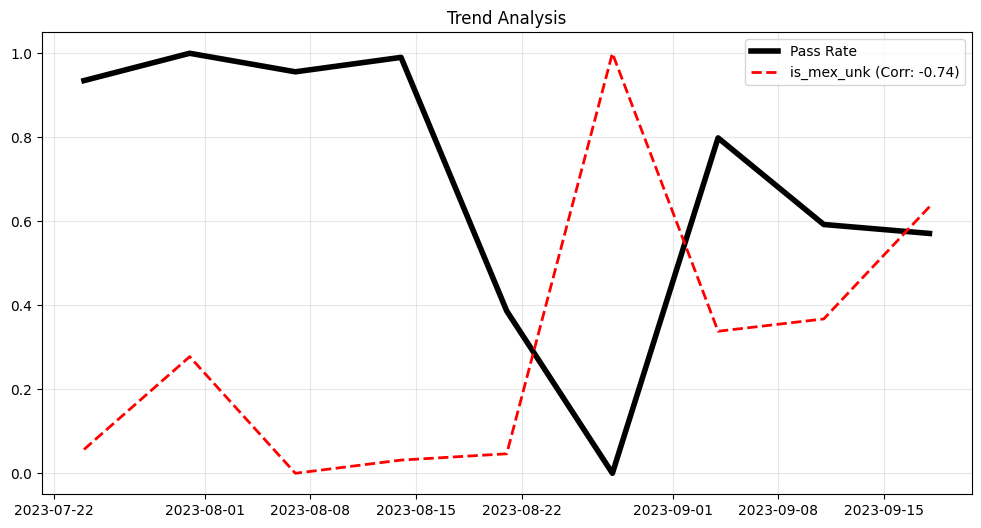

In [109]:
normalized_weekly = (agg_data - agg_data.min()) / (agg_data.max() - agg_data.min())

plt.figure(figsize=(12, 6))
plt.plot(normalized_weekly.index, normalized_weekly['is_pass'], linewidth=4, color='black', label='Pass Rate')

top_suspect = "is_mex_unk"

plt.plot(
    normalized_weekly.index,
    normalized_weekly[top_suspect],
    linewidth=2,
    linestyle='--',
    color="red",
    label=f'{top_suspect} (Corr: {correlation_matrix[top_suspect]:.2f})'
)

plt.title('Trend Analysis')
plt.legend()
plt.grid(True, alpha=0.3)

In [112]:
df_clean['is_mex_unk_tech_fail'] = (
    (df_clean['is_mex_unk'] == 1) &
    (df_clean['is_tech_data_fail'] == 1)
).astype(int)

df_clean['is_mex_unk_unssuported_document'] = (
    (df_clean['is_mex_unk'] == 1) &
    (df_clean['is_unsupported_doc'] == 1)
).astype(int)

df_clean['is_mex_unk_quality_fail'] = (
    (df_clean['is_mex_unk'] == 1) &
    (df_clean['is_quality_fail'] == 1)
).astype(int)

df_clean['is_mex_unk_mismatch'] = (
    (df_clean['is_mex_unk'] == 1) &
    (df_clean['is_face_mismatch'] == 1)
).astype(int)

df_clean['is_mex_unk_fraud'] = (
    (df_clean['is_mex_unk'] == 1) &
    (df_clean['is_confirmed_fraud'] == 1)
).astype(int)

In [113]:
weekly_data_unkown = df_clean.groupby('week').agg({
    'is_pass': 'mean',
    'is_mex_unk_tech_fail': 'mean',
    'is_mex_unk_unssuported_document': 'mean',
    'is_mex_unk_quality_fail': 'mean',
    'is_mex_unk_mismatch': 'mean',
    'is_mex_unk_fraud': 'mean',
})

In [191]:
correlation_matrix = weekly_data_unkown.corr()['is_pass'].drop('is_pass').sort_values()
correlation_matrix

,is_pass
is_mex_unk_unssuported_document,-0.590785
is_mex_unk_fraud,-0.182953
is_mex_unk_quality_fail,0.044788
is_mex_unk_tech_fail,0.268382
is_mex_unk_mismatch,0.394470


In [118]:
correlation_matrix = weekly_data_unkown.corr(method="spearman")['is_pass'].drop('is_pass').sort_values()
correlation_matrix

,is_pass
is_mex_unk_unssuported_document,-0.450000
is_mex_unk_fraud,-0.250000
is_mex_unk_tech_fail,0.136931
is_mex_unk_quality_fail,0.183333
is_mex_unk_mismatch,0.250000


In [148]:
mex_unk_cohort = df_clean[
    (df_clean['is_mex_unk'] == 1)
].copy()

In [149]:
mex_unk_cohort.groupby("usability_decision_details")["user_reference"].count()

,user_reference
usability_decision_details,
BLURRED,215
DAMAGED_DOCUMENT,50
GLARE,96
MISSING_MANDATORY_DATAPOINTS,407
MISSING_PAGE,138
NOT_A_DOCUMENT,3
NOT_UPLOADED,19
OK,2179
PART_OF_DOCUMENT_HIDDEN,2


In [151]:
mex_unk_cohort_bugs = mex_unk_cohort[
    (mex_unk_cohort['usability_decision_details'] == 'OK')
]

In [152]:
mex_unk_cohort_bugs.groupby("image_checks_decision_details")["user_reference"].count()

,user_reference
image_checks_decision_details,
DIGITAL_COPY,157
PRECONDITION_NOT_FULFILLED,2021
TECHNICAL_ERROR,1


In [153]:
mex_unk_cohort_bugs.groupby("extraction_decision_details")["user_reference"].count()

,user_reference
extraction_decision_details,
OK,157
PRECONDITION_NOT_FULFILLED,2021
TECHNICAL_ERROR,1


In [154]:
mex_unk_cohort_bugs.groupby("data_checks_decision_details")["user_reference"].count()

,user_reference
data_checks_decision_details,
PRECONDITION_NOT_FULFILLED,2178
TECHNICAL_ERROR,1


In [155]:
mex_unk_cohort_bugs.groupby("liveness_decision_details")["user_reference"].count()

,user_reference
liveness_decision_details,
BAD_QUALITY,3
OK,2146
TECHNICAL_ERROR,1
liveness_UNDETERMINED,29


In [157]:
mex_unk_cohort_bugs.groupby("similarity_decision_details")["user_reference"].count()

,user_reference
similarity_decision_details,
MATCH,856
NOT_POSSIBLE,13
NO_MATCH,37
PRECONDITION_NOT_FULFILLED,1272
TECHNICAL_ERROR,1


In [169]:
bug_cohort = df_clean[
    (df_clean['data_issuing_country'] == 'MEX') &
    (df_clean['data_type'] == 'UNKOWN') &
    (df_clean['usability_decision_details'] == 'OK')
].copy()

control_cohort = df_clean[
    (df_clean['data_issuing_country'] == 'MEX') &
    (~(df_clean['data_type'] == 'UNKOWN')) &
    (df_clean['usability_decision_details'] == 'OK')
].copy()

In [170]:
bug_counts = bug_cohort['image_checks_decision_details'].value_counts()
control_counts = control_cohort['image_checks_decision_details'].value_counts()

In [171]:
print(f"Total Users in Bug Cohort (MEX + UNK + Usability OK): {len(bug_cohort)}")
print("\nImage Checks Outcome for Bug Cohort:")
print(bug_counts)

print(f"\nTotal Users in Control Cohort (MEX + Known Doc + Usability OK): {len(control_cohort)}")
print("\nImage Checks Outcome for Control Cohort (Top 5):")
print(control_counts.head())

Total Users in Bug Cohort (MEX + UNK + Usability OK): 2179

Image Checks Outcome for Bug Cohort:
image_checks_decision_details
PRECONDITION_NOT_FULFILLED    2021
DIGITAL_COPY                   157
TECHNICAL_ERROR                  1
Name: count, dtype: int64

Total Users in Control Cohort (MEX + Known Doc + Usability OK): 25531

Image Checks Outcome for Control Cohort (Top 5):
image_checks_decision_details
OK                            25314
MANIPULATED_DOCUMENT            123
MANIPULATED_DOCUMENT_PHOTO       25
MANIPULATED_DOCUMENT_DOB         20
DIGITAL_COPY                     16
Name: count, dtype: int64


In [172]:
bug_impossible_rate = (bug_counts.get('PRECONDITION_NOT_FULFILLED', 0) / len(bug_cohort)) * 100
control_impossible_rate = (control_counts.get('PRECONDITION_NOT_FULFILLED', 0) / len(control_cohort)) * 100

print(f"\n% of Users getting 'PRECONDITION FAIL' after 'USABILITY OK':")
print(f"  - Bug Cohort: {bug_impossible_rate:.2f}%")
print(f"  - Control Cohort: {control_impossible_rate:.2f}%")


% of Users getting 'PRECONDITION FAIL' after 'USABILITY OK':
  - Bug Cohort: 92.75%
  - Control Cohort: 0.00%


In [173]:
bug_cohort['is_impossible'] = (bug_cohort['image_checks_decision_details'] == 'PRECONDITION_NOT_FULFILLED').astype(int)
daily_bug_vol = bug_cohort.groupby('week')['is_impossible'].sum()

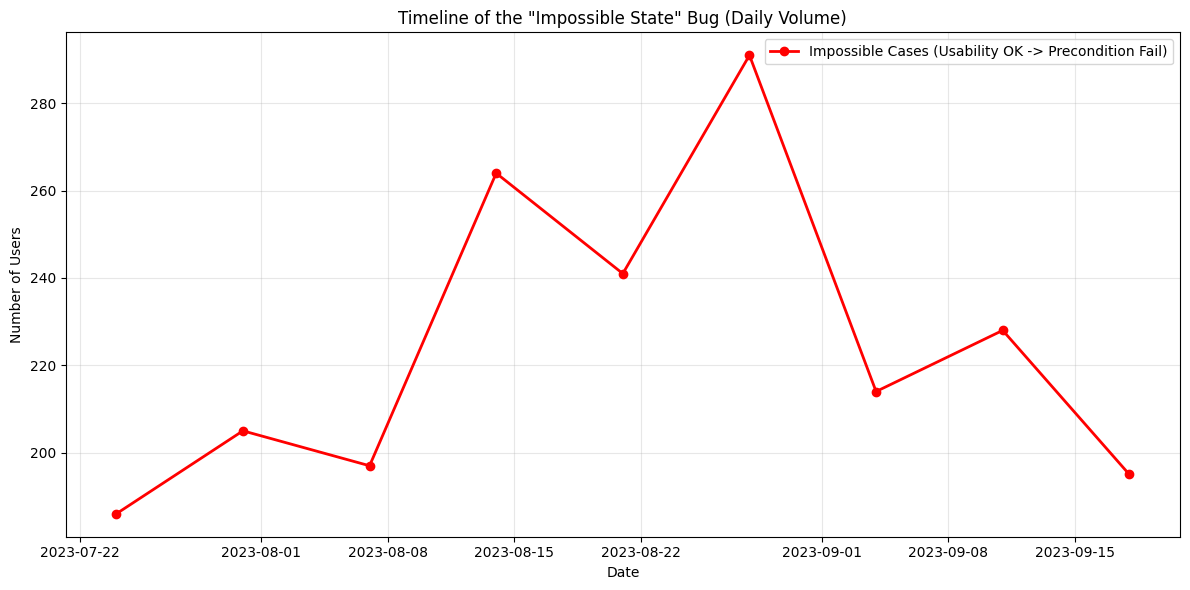

In [174]:
plt.figure(figsize=(12, 6))
plt.plot(daily_bug_vol.index, daily_bug_vol.values, color='red', marker='o', linewidth=2, label='Impossible Cases (Usability OK -> Precondition Fail)')
plt.title('Timeline of the "Impossible State" Bug (Daily Volume)')
plt.ylabel('Number of Users')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

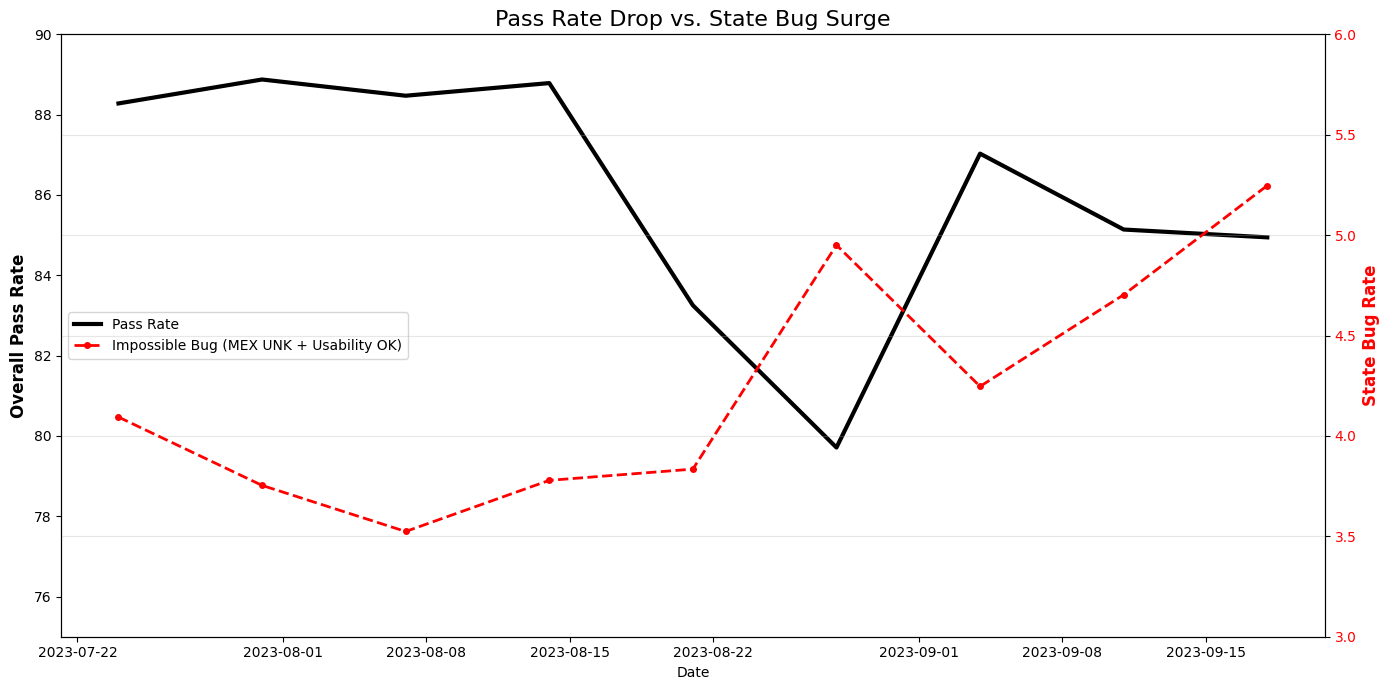

In [189]:
df_clean['is_impossible_bug'] = (
    (df_clean['data_issuing_country'] == 'MEX') &
    (df_clean['data_type'] == 'UNKOWN') &
    (df_clean['usability_decision_details'] == 'OK')
).astype(int)

daily_stats = df_clean.groupby('week').agg({
    'decision_type': lambda x: x.isin(['PASSED', 'APPROVED']).mean(),
    'is_impossible_bug': 'mean'
})
daily_stats.columns = ['Pass_Rate', 'Impossible_Bug_Rate']

daily_stats['Pass_Rate_Pct'] = daily_stats['Pass_Rate'] * 100
daily_stats['Impossible_Bug_Rate_Pct'] = daily_stats['Impossible_Bug_Rate'] * 100

fig, ax1 = plt.subplots(figsize=(14, 7))

color_pass = 'black'
ax1.set_xlabel('Date')
ax1.set_ylabel('Overall Pass Rate', color=color_pass, fontweight='bold', fontsize=12)
ax1.plot(daily_stats.index, daily_stats['Pass_Rate_Pct'], color=color_pass, linewidth=3, label='Pass Rate')
ax1.tick_params(axis='y', labelcolor=color_pass)
ax1.set_ylim(75, 90)
ax1.grid(False)

ax2 = ax1.twinx()
color_bug = 'red'
ax2.set_ylabel('State Bug Rate', color=color_bug, fontweight='bold', fontsize=12)
ax2.plot(daily_stats.index, daily_stats['Impossible_Bug_Rate_Pct'], color=color_bug, linestyle='--', linewidth=2, marker='o', markersize=4, label='Impossible Bug (MEX UNK + Usability OK)')
ax2.tick_params(axis='y', labelcolor=color_bug)
ax2.set_ylim(3, 6)
ax2.grid(True, alpha=0.3)

plt.title('Pass Rate Drop vs. State Bug Surge', fontsize=16)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center left')

plt.tight_layout()

In [179]:
daily_stats

,Pass_Rate,Impossible_Bug_Rate,Pass_Rate_Pct,Impossible_Bug_Rate_Pct
week,,,,
2023-07-24,0.882793,0.040939,88.279302,4.093932
2023-07-31,0.888756,0.037536,88.875618,3.753626
2023-08-07,0.884712,0.035241,88.471220,3.524081
2023-08-14,0.887862,0.037787,88.786190,3.778714
2023-08-21,0.832525,0.038347,83.252465,3.834716
2023-08-28,0.797111,0.049505,79.711086,4.950495
2023-09-04,0.870291,0.042466,87.029140,4.246624
2023-09-11,0.851395,0.047031,85.139485,4.703147
2023-09-18,0.849445,0.052470,84.944458,5.246987


In [181]:
daily_stats.corr().iloc[0, 1]

np.float64(-0.6428212244835461)